In [1]:
library(tidyverse)
library(gridExtra)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked

#### Brief Description of this dataset

> I decided to add "Language" as my categorical explanatory variable and change variable "Watchers" to "Issues".
>* Stars: The number of stars or likes that the repository has received from other GitHub users, indicating its popularity or interest
>* Forks: The number of times the repository has been forked by other GitHub users
>* Issues: The total number of open issues (indicating bugs, feature requests, or discussions)
>* Language: The primary programming language

 **Question**: This project will aim to explore the relationship between these variables. Specifically, I am going to investigate if the number of stars and issues within each programming language is related to the change in a number of repositories being forked.

## Cleaning and Wrangling Data

In [2]:
github_data <- read_csv("repositories.csv")
# Since there are over 215k observations, I decided to observe only 5000
github_sample <- github_data[sample(nrow(github_data), 5000),]
head(github_sample)

Rows: 215029 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): Name, Description, URL, Homepage, Language, License, Topics, Defau...
dbl  (5): Size, Stars, Forks, Issues, Watchers
lgl  (9): Has Issues, Has Projects, Has Downloads, Has Wiki, Has Pages, Has ...
dttm (2): Created At, Updated At

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Name                           
1 crystal-book                   
2 jq-console                     
3 lm-sensors                     
4 zeno                           
5 direct_visual_lidar_calibration
6 deeplabv3plus-pytorch          
  Description                                                                                                                                                           
1 Crystal docs at https://crystal-lang.org/reference                                                                                                                    
2 Feature complete web terminal                                                                                                                                         
3 lm-sensors repository                                                                                                                                                 
4 Netflix's In-Memory Data Propagation Framework                                                                                                                        
5 A toolbox for target-less LiDAR-camera calibration [ROS1/ROS2]                                                                                                        
6 Here is a pytorch implementation of deeplabv3+ supporting ResNet(79.155%) and Xception(79.945%). Multi-scale & flip test and COCO dataset interface has been finished.
  URL                                                       Created At         
1 https://github.com/crystal-lang/crystal-book              2016-06-27 18:56:46
2 https://github.com/replit-archive/jq-console              2011-03-25 20:30:20
3 https://github.com/lm-sensors/lm-sensors                  2011-12-20 22:29:46
4 https://github.com/Netflix/zeno                           2013-10-28 17:36:46
5 https://github.com/koide3/direct_visual_lidar_calibration 2022-09-13 01:06:03
6 https://github.com/YudeWang/deeplabv3plus-pytorch         2018-09-14 11:40:35
  Updated At          Homepage                                                 
1 2023-09-11 01:10:02 NA                                                       
2 2023-08-22 19:10:56 http://replit.github.com/jq-console/                     
3 2023-09-21 03:02:19 https://hwmon.wiki.kernel.org/                           
4 2023-04-12 07:27:17 NA                                                       
5 2023-09-25 02:09:17 https://koide3.github.io/direct_visual_lidar_calibration/
6 2023-09-23 01:30:30 NA                                                       
  Size  Stars Forks Issues ⋯ Has Issues Has Projects Has Downloads Has Wiki
1  1346 377   249    65    ⋯ TRUE       TRUE         TRUE          TRUE    
2   670 612   112    19    ⋯ TRUE       TRUE         TRUE          TRUE    
3 20517 786   239   228    ⋯ TRUE       TRUE         TRUE          TRUE    
4  5320 200    64     6    ⋯ TRUE       TRUE         TRUE          TRUE    
5   834 362    37     9    ⋯ TRUE       TRUE         TRUE          TRUE    
6   247 612   116     9    ⋯ TRUE       TRUE         TRUE          TRUE    
  Has Pages Has Discussions Is Fork Is Archived Is Template Default Branch
1 FALSE     FALSE           FALSE   FALSE       FALSE       master        
2  TRUE     FALSE           FALSE   FALSE       FALSE       master        
3 FALSE     FALSE           FALSE   FALSE       FALSE       master        
4  TRUE     FALSE           FALSE   FALSE       FALSE       master        
5  TRUE     FALSE           FALSE   FALSE       FALSE       main          
6 FALSE     FALSE           FALSE   FALSE       FALSE       master

In [3]:
# Include only four main languages
github_sample <- subset(github_sample, Language %in% c("Python", "JavaScript", "Java", "C++"))

I will observe four main languages, "Python", "JavaScript", "Java", and "C++".

I had to change one of my explanatory variable, "Watchers", to "Issues" since Watchers and Stars have the exact same values.

In [4]:
# Check if interested variables has any N/A values
sum(is.na(github_sample$Forks))
sum(is.na(github_sample$Issues))
sum(is.na(github_sample$Language))

[1] 0

[1] 0

[1] 0

There is no missing values

In [5]:
# Check if there are any duplicated value
sum(duplicated(github_sample))

[1] 0

There is no duplicated value

In [6]:
variables <- github_sample %>% select(Forks,Stars,Issues)
Summary <- summary(variables)
Summary

     Forks             Stars           Issues       
 Min.   :    0.0   Min.   :  167   Min.   :   0.00  
 1st Qu.:   43.0   1st Qu.:  240   1st Qu.:   4.00  
 Median :   84.0   Median :  371   Median :  11.00  
 Mean   :  228.1   Mean   : 1051   Mean   :  39.01  
 3rd Qu.:  182.0   3rd Qu.:  798   3rd Qu.:  30.00  
 Max.   :20863.0   Max.   :61118   Max.   :1955.00  

We want to exclude the outliers to preserve normality and reduce variability .

In [7]:
 # Excluding the outliers
github_sample <- github_sample %>%
                 filter(Forks <= 250 & Stars <= 1000 & Issues <= 60)

In [8]:
head(github_sample)

Name                           
1 zeno                           
2 direct_visual_lidar_calibration
3 deeplabv3plus-pytorch          
4 code-run                       
5 basisjs                        
6 Calendar.js                    
  Description                                                                                                                                                           
1 Netflix's In-Memory Data Propagation Framework                                                                                                                        
2 A toolbox for target-less LiDAR-camera calibration [ROS1/ROS2]                                                                                                        
3 Here is a pytorch implementation of deeplabv3+ supporting ResNet(79.155%) and Xception(79.945%). Multi-scale & flip test and COCO dataset interface has been finished.
4 一个代码在线编辑预览工具，类似codepen、jsbin、jsfiddle等。                                                                                                            
5 JavaScript framework to build single page applications                                                                                                                
6 📅 A javascript drag & drop event calendar, that is fully responsive and compatible with all modern browsers.                                                         
  URL                                                       Created At         
1 https://github.com/Netflix/zeno                           2013-10-28 17:36:46
2 https://github.com/koide3/direct_visual_lidar_calibration 2022-09-13 01:06:03
3 https://github.com/YudeWang/deeplabv3plus-pytorch         2018-09-14 11:40:35
4 https://github.com/wanglin2/code-run                      2021-04-27 05:59:23
5 https://github.com/basisjs/basisjs                        2012-06-07 08:05:47
6 https://github.com/williamtroup/Calendar.js               2021-02-24 20:05:09
  Updated At          Homepage                                                 
1 2023-04-12 07:27:17 NA                                                       
2 2023-09-25 02:09:17 https://koide3.github.io/direct_visual_lidar_calibration/
3 2023-09-23 01:30:30 NA                                                       
4 2023-09-23 14:07:53 https://wanglin2.github.io/code-run/                     
5 2023-09-14 07:03:14 http://basisjs.com                                       
6 2023-09-25 07:11:24 https://williamtroup.github.io/Calendar.js/              
  Size  Stars Forks Issues ⋯ Has Issues Has Projects Has Downloads Has Wiki
1  5320 200    64    6     ⋯ TRUE        TRUE        TRUE           TRUE   
2   834 362    37    9     ⋯ TRUE        TRUE        TRUE           TRUE   
3   247 612   116    9     ⋯ TRUE        TRUE        TRUE           TRUE   
4 22858 406   114    4     ⋯ TRUE        TRUE        TRUE           TRUE   
5 17676 383    34   39     ⋯ TRUE        TRUE        TRUE          FALSE   
6  9550 193    11    0     ⋯ TRUE       FALSE        TRUE          FALSE   
  Has Pages Has Discussions Is Fork Is Archived Is Template Default Branch
1  TRUE     FALSE           FALSE   FALSE       FALSE       master        
2  TRUE     FALSE           FALSE   FALSE       FALSE       main          
3 FALSE     FALSE           FALSE   FALSE       FALSE       master        
4  TRUE     FALSE           FALSE   FALSE       FALSE       main          
5 FALSE     FALSE           FALSE   FALSE       FALSE       master        
6  TRUE      TRUE           FALSE   FALSE       FALSE       main

#### Focusing on our explanatory and response variables

In [9]:
github_cleaned <- github_sample %>%
    select(Language,Stars,Issues,Forks) 
head(github_cleaned)

Language   Stars Issues Forks
1 Java       200    6      64  
2 C++        362    9      37  
3 Python     612    9     116  
4 JavaScript 406    4     114  
5 JavaScript 383   39      34  
6 JavaScript 193    0      11

## Exploratory Data Analysis and Visualization

First, we are going to interpret our continuous variables.

In [361]:
github_cont <- github_cleaned %>% select(Stars, Issues)
head(github_cont)

Stars Issues
1 314    5    
2 274    6    
3 353   14    
4 472   20    
5 209    4    
6 191   24

In [362]:
summary_cont <- summary(github_cont)
summary_cont

     Stars           Issues    
 Min.   :167.0   Min.   : 0.0  
 1st Qu.:215.0   1st Qu.: 2.0  
 Median :291.0   Median : 8.0  
 Mean   :362.7   Mean   :12.5  
 3rd Qu.:452.0   3rd Qu.:18.0  
 Max.   :991.0   Max.   :60.0  

In [363]:
Forks_mean <- github_cleaned %>%
group_by(Language) %>%
summarise(Forks = mean(as.numeric(Forks)), .groups = 'drop')
Forks_mean

Language   Forks   
1 C++        76.86747
2 Java       98.11111
3 JavaScript 67.99810
4 Python     71.70568

> Now, I will explore the correlationship between continuous variables in our dataset.

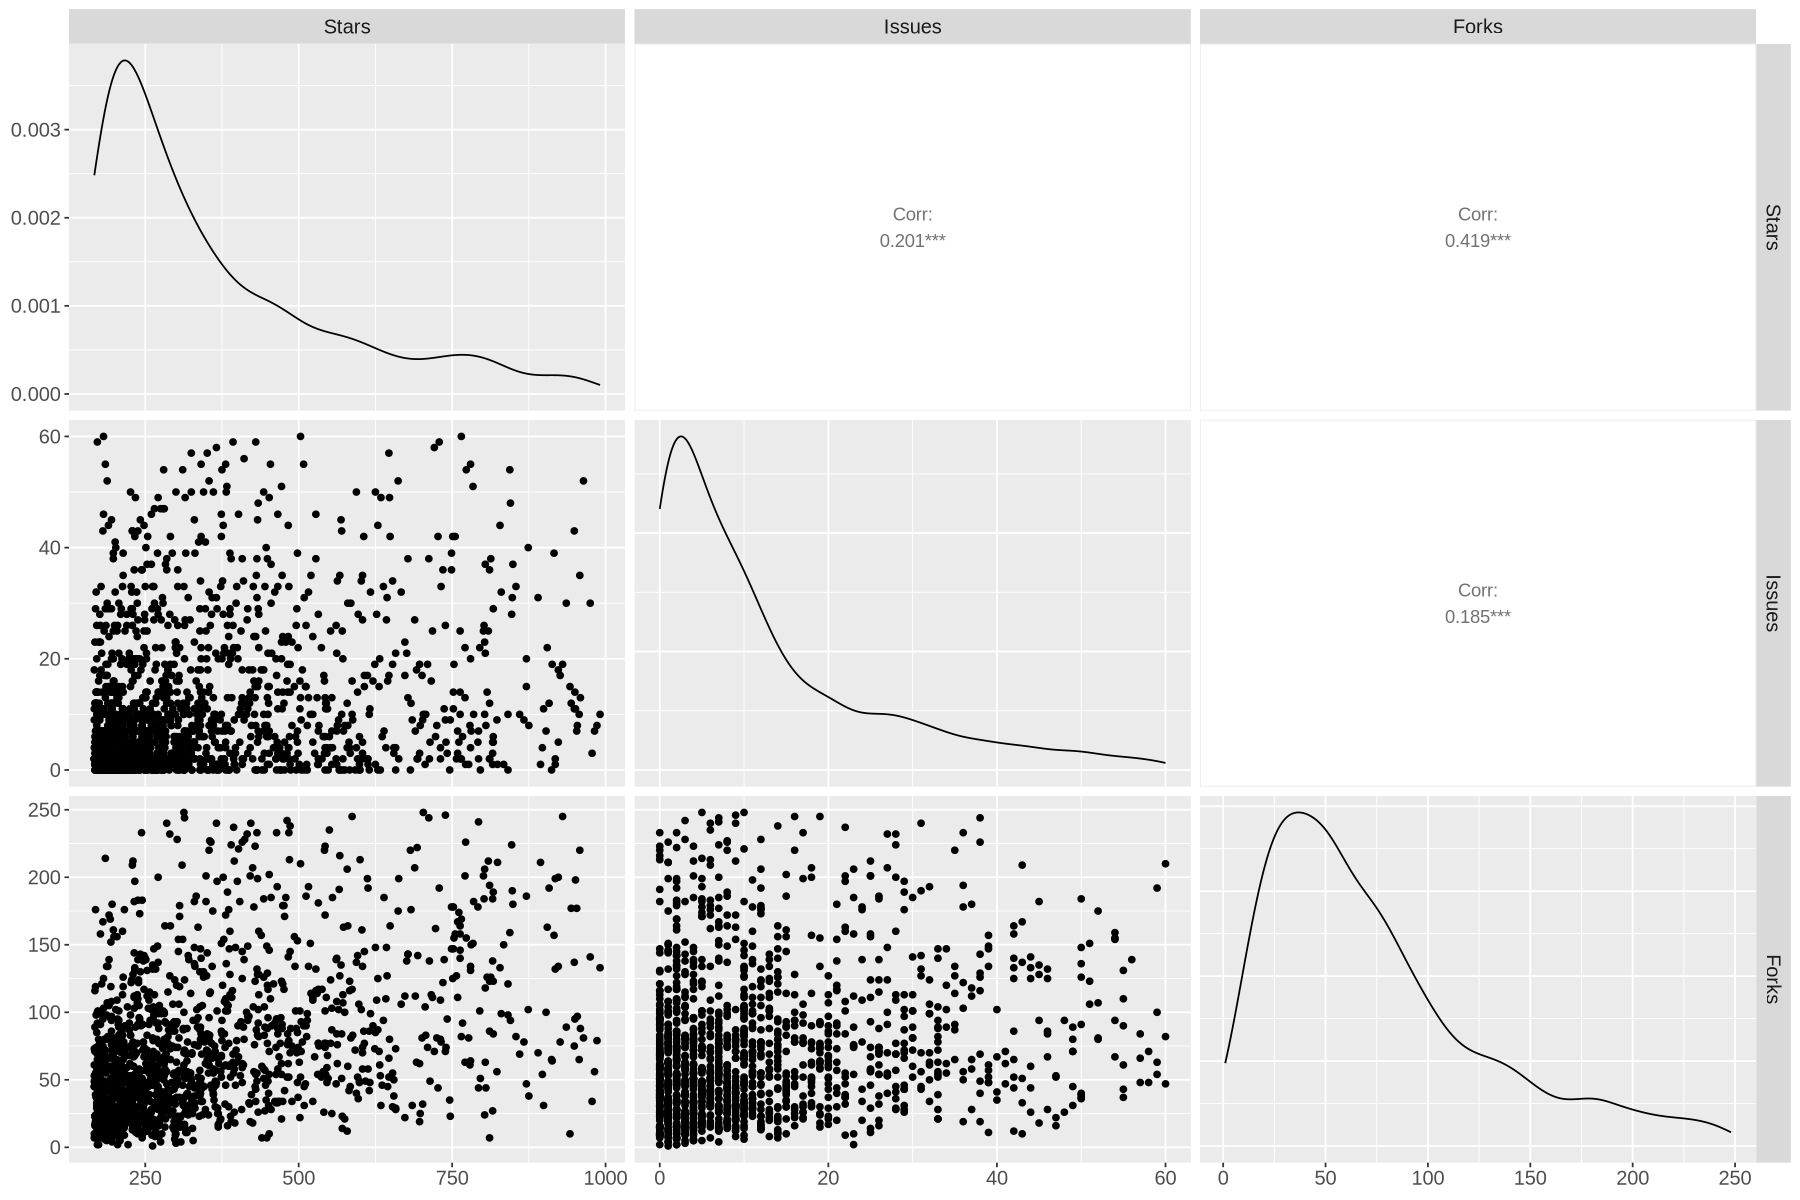

In [364]:
 github_pair_plots <- github_cleaned %>%
   select(- Language) %>% 
   ggpairs(progress = FALSE) +
   theme(
     text = element_text(size = 15),
     plot.title = element_text(face = "bold"),
     axis.title = element_text(face = "bold")
   )
 github_pair_plots

A grid of pairwise scatterplots for the variables in the  dataset, excluding the Language.

In [365]:
corr_matrix_github <- github_cleaned %>%
   select(- Language) %>% 
   cor() %>%
   as.data.frame() %>%
   rownames_to_column("var1") %>%
   pivot_longer(-var1, names_to = "var2", values_to = "corr")
 corr_matrix_github

var1   var2   corr     
1 Stars  Stars  1.0000000
2 Stars  Issues 0.2012829
3 Stars  Forks  0.4188116
4 Issues Stars  0.2012829
5 Issues Issues 1.0000000
6 Issues Forks  0.1852428
7 Forks  Stars  0.4188116
8 Forks  Issues 0.1852428
9 Forks  Forks  1.0000000

The correlation chart for the variables in the  dataset, excluding the Language variable. 

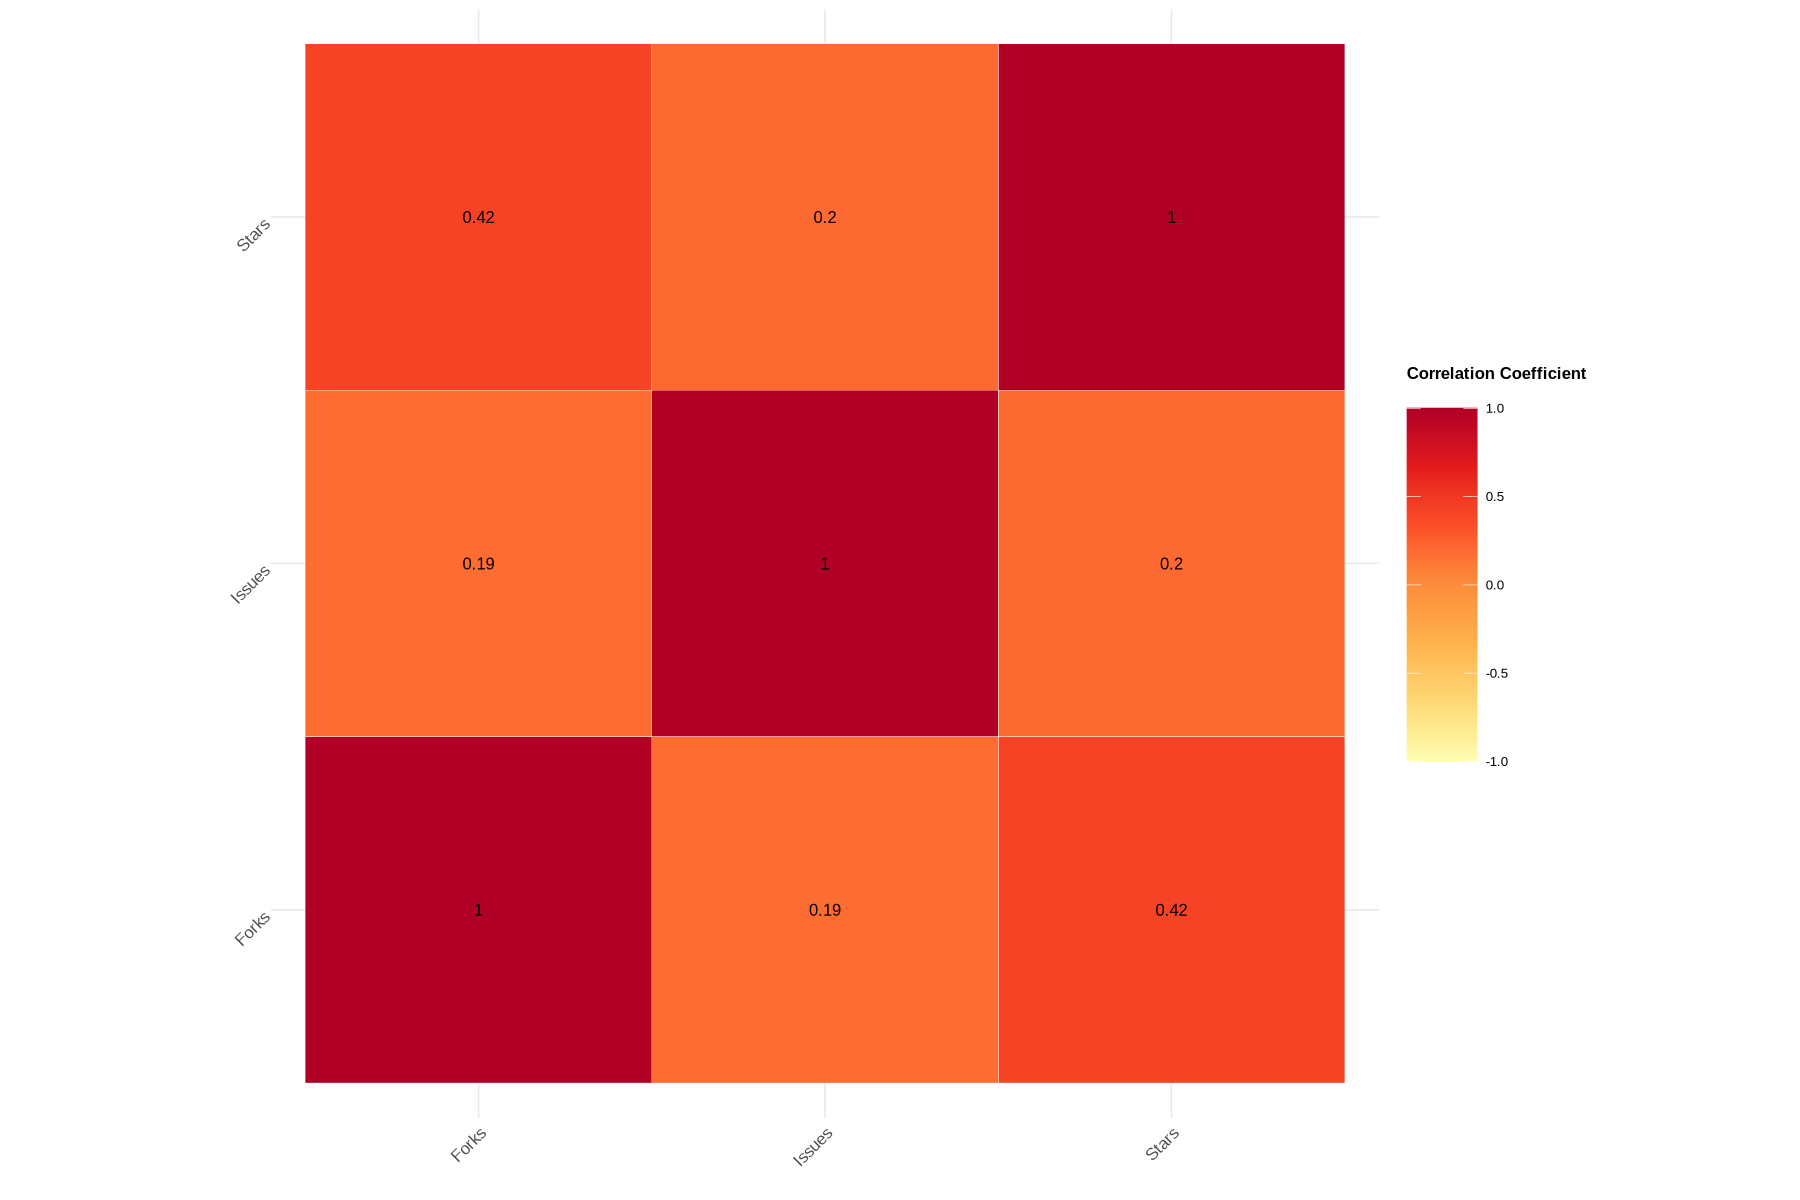

In [366]:
plot_corr_matrix_github <- corr_matrix_github %>%
  ggplot(aes(var1, var2, fill = corr)) +
  geom_tile(color = "white") +
  scale_fill_distiller("Correlation Coefficient \n", palette = "YlOrRd", direction = 1, limits = c(-1, 1)) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 10),
    axis.text.y = element_text(angle = 45, vjust = 1, hjust=1, size = 10),
    legend.title = element_text(size = 10, face = "bold"),
    legend.key.size = unit(1.5, "cm"), 
    legend.text = element_text(size = 8) 
  ) +
  coord_fixed() +
  geom_text(aes(label = round(corr, 2)), color = "black", size = 3.5) # adjust the size of the text here

# Display the heat map
plot_corr_matrix_github


A heatmap-style plot representing the correlation matrix of variables in the dataset.

In [367]:
boxplot1<- ggplot(github_cleaned, aes(x=Language, y=Forks, fill=Language)) +
  geom_boxplot() +
  xlab("Programming Language") +
  ylab("Number of Forks") +
  ggtitle("Boxplot of Forks by Programming Language") +
  theme_minimal()

boxplot2  <- github_cleaned %>%
ggplot(aes(x = Stars, y = Forks, fill = Language)) + 
geom_boxplot() +
xlab("Stars") + 
ylab("Forks") + 
ggtitle("Relationship Between Stars and Forks by Language") +
  theme_minimal()

boxplot3  <- github_cleaned %>%
ggplot(aes(x = Issues, y = Forks, fill = Language)) + 
geom_boxplot() +
xlab("Issues") + 
ylab("Forks") + 
ggtitle("Relationship Between Issues and Forks by Language") +
  theme_minimal()

> Then we are going to explore the continuous variables (Stars, Issues) relate to the number of Forks across different programming languages.

In [368]:
Scatterplot1<-ggplot(github_cleaned, aes(x=Stars, y=Forks, color=Language)) +
  geom_point() +
  facet_wrap(~ Language) +
  labs(title="Stars vs. Forks by Programming Language", x="Stars", y="Forks") +
  theme_minimal()



Scatterplot2<-ggplot(github_cleaned, aes(x=Issues, y=Forks, color=Language)) +
  geom_point() +
  facet_wrap(~ Language) +
  labs(title="Issues vs. Forks by Programming Language", x="Issues", y="Forks") +
  theme_minimal()


In [369]:
bar_chart1 = ggplot(github_cleaned, aes(x = Stars, y = Forks, fill = Language)) +
  geom_bar(stat = "identity",width = 20) + 
  facet_wrap(~ Language) +
  ggtitle("Stars vs Forks for each Language") + 
  labs(x = "Stars", y = "Forks", fill = "Language") +
   scale_fill_brewer(palette = "Set2") + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1))


bar_chart2 = ggplot(github_cleaned, aes(x = Issues, y = Forks, fill = Language)) +
  geom_bar(stat = "identity",width = 1) + 
  facet_wrap(~ Language) +
  ggtitle("Issues vs Forks for each Language") + 
  labs(x = "Issues", y = "Forks", fill = "Language") +
   scale_fill_brewer(palette = "Set1") + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1))


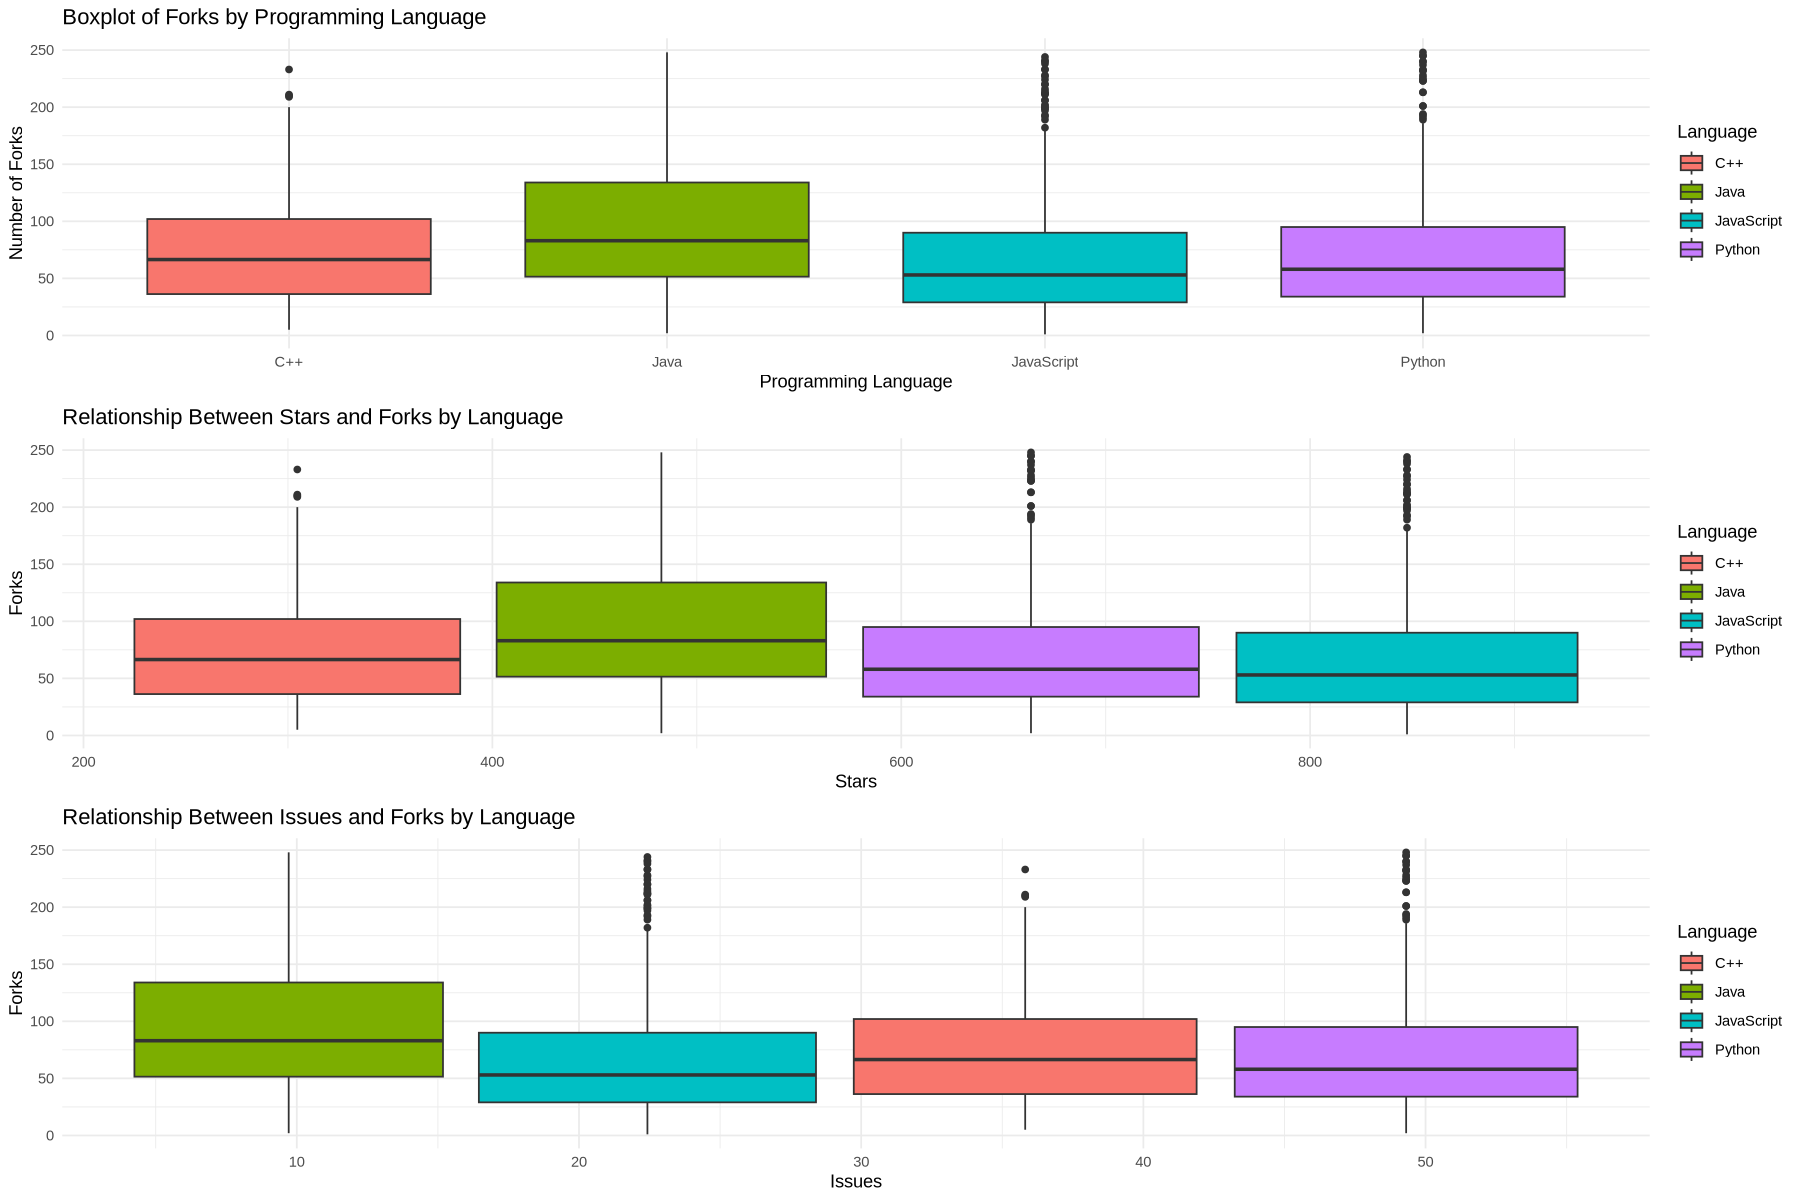

Warning message:
“`position_stack()` requires non-overlapping x intervals”
Warning message:
“`position_stack()` requires non-overlapping x intervals”
Warning message:
“`position_stack()` requires non-overlapping x intervals”
Warning message:
“`position_stack()` requires non-overlapping x intervals”


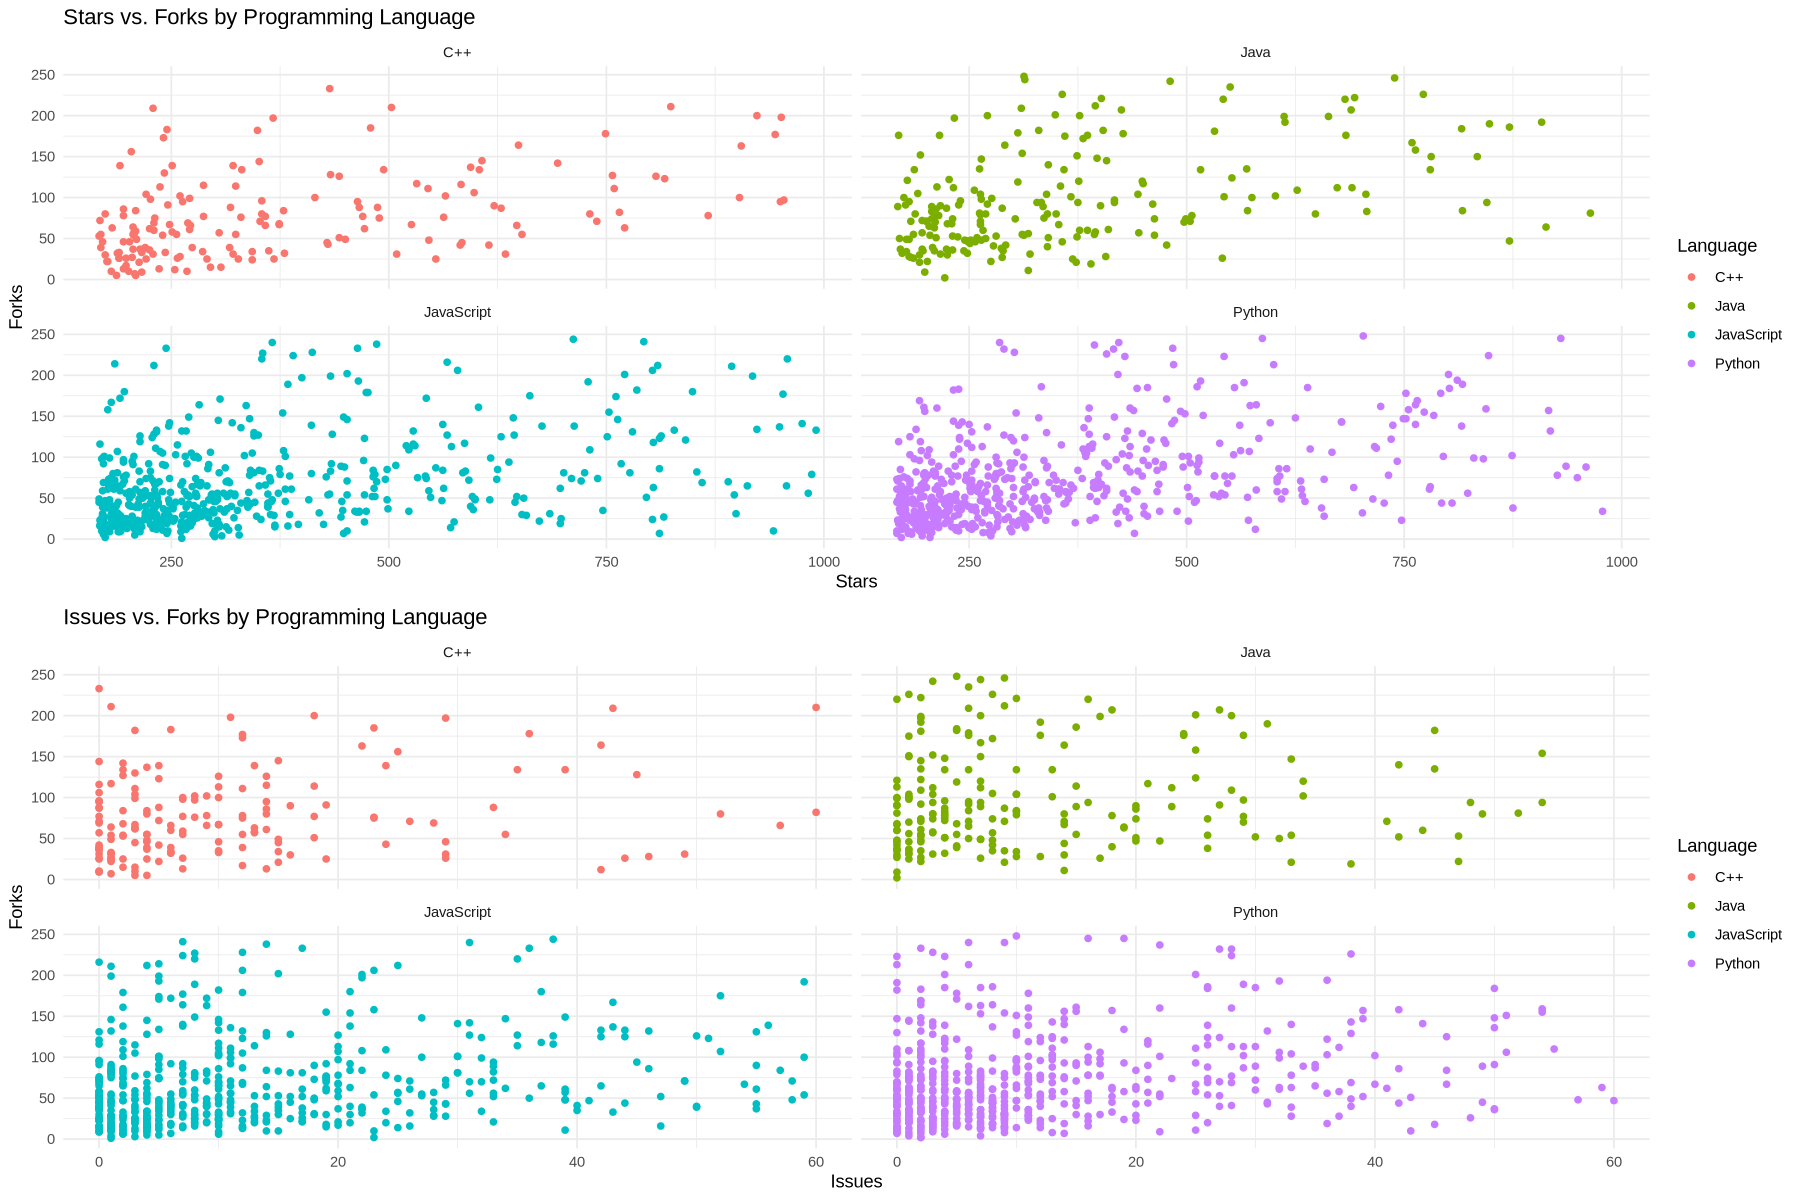

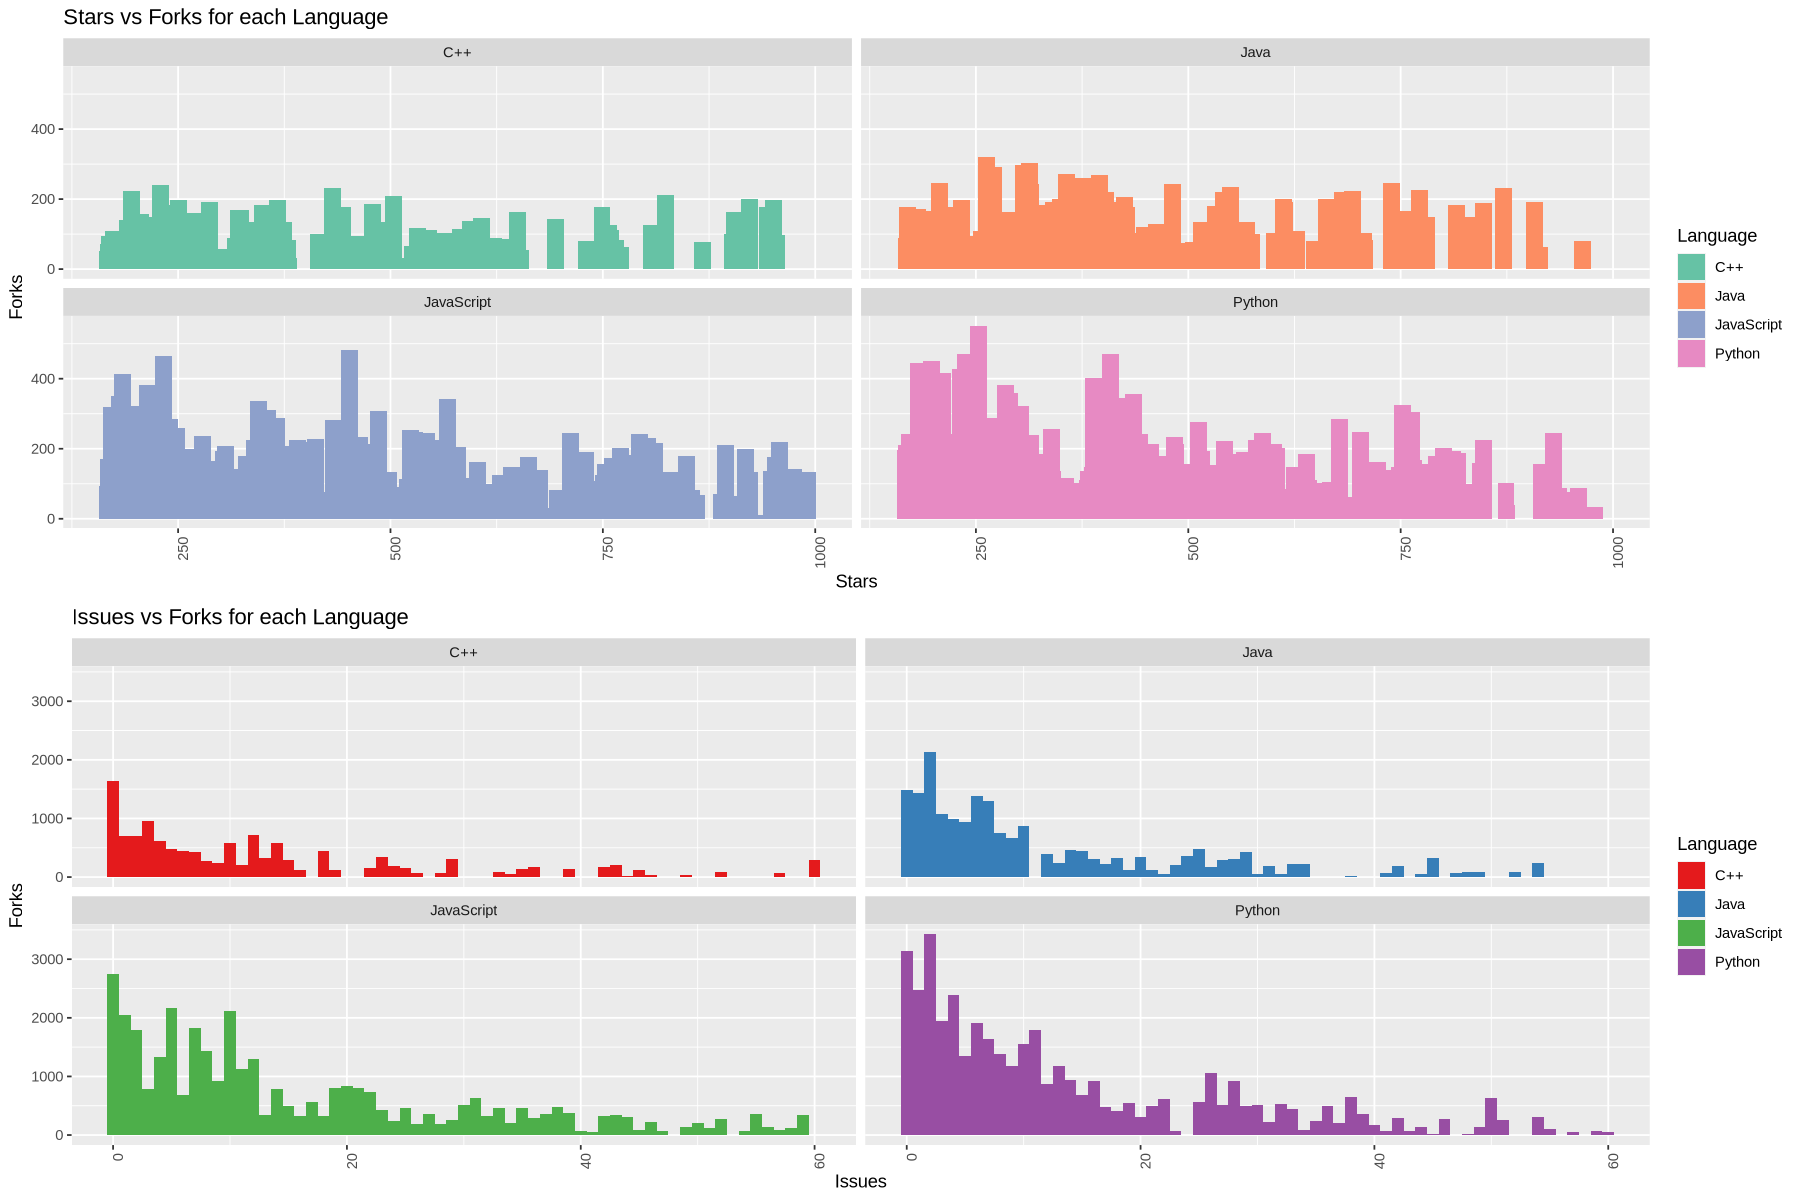

In [370]:
grid.arrange(boxplot1,boxplot2,boxplot3)
grid.arrange(Scatterplot1,Scatterplot2)
grid.arrange(bar_chart1,bar_chart2)

> These plots provide a visualized exploration of data to answer the question of whether a number of 'Forks' are dependent on both categorical(Language) and continuous (Stars, Issues) explanatory variables.



**Boxplot**

* First boxplot allows us to compare the distribution of a number of 'Forks' across different programming languages. By examining the spread of the boxes, we can assess the variability in a number of 'Forks' within each language. Additionally, comparing the medians between languages allows us to identify any significant differences in the distribution of 'Fork' counts across programming languages on GitHub.

* Second boxplot represents the distribution of fork counts for repositories within different programming languages, grouped by their number of stars. Each boxplot provides insight into how the number of forks varies across repositories by the number of stars within each language.

* Third boxplot depicts boxplots representing the distribution of fork counts for repositories within different programming languages, but grouped by the number of issues. Each boxplot reveals how the number of forks varies across repositories by different numbers of issues within each language.

**Scatterplot**
* First scatterplot visualizes the relationship between the number of stars and the number of forks for repositories across various programming languages.  The plot allows us to observe whether there's a correlation between the popularity of a repository and the forking activity.

* Second scatterplot illustrates the relationship between the number of issues and the number of forks for repositories across programming languages. The plot enables us to explore whether there's any association between the issue activity and forking activity across different repositories within each programming language.

**Bar Chart**
* First bar chart illustrates the relationship between the number of stars and the number of forks for repositories within different programming languages.

* Second bar chart demonstrates the relationship between the number of issues and forks for repositories within different programming languages. 